---
# 1. 필요 라이브러리 불러오기
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib.pylab import rcParams
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import imageio

print(tf.__version__)
print(imageio.__version__)
print("tensorflow", tf.__version__)

2.8.2
2.4.1
tensorflow 2.8.2


---
# 2. 데이터셋 구성하기
---

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 픽셀의 최대,최소 크기 확인

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- -1과 1로 정규화 하기

In [ ]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- shape 확인

In [ ]:
train_x.shape

(50000, 32, 32, 3)

- 이미지로 확인해보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


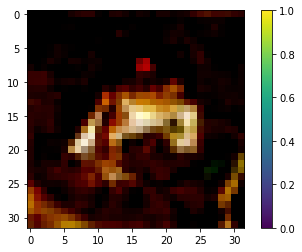

In [ ]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

- 로드한 데이터 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

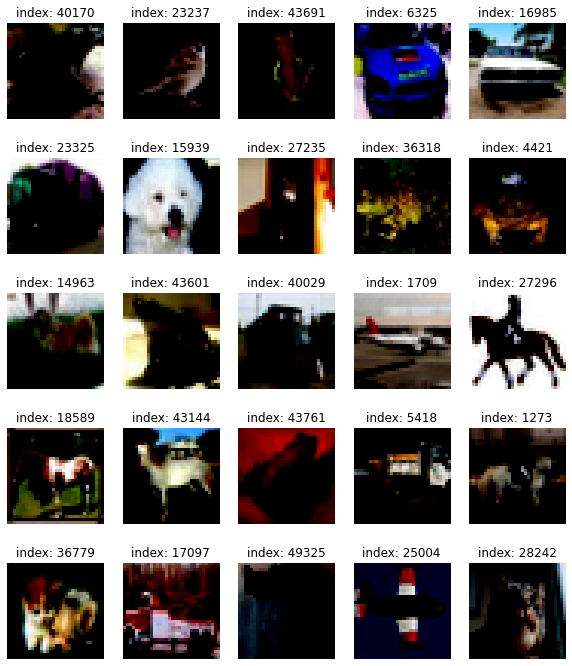

In [ ]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

- 이미지 개수만큼 buffer_size설정
- 배치 사이즈는 기존 보다 한 단계 축소

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

- 미니배치 데이터셋 구성

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

----
# 3. 생성자 구현하기
---

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((2, 2, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # seventh: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

output의 shape이 갑작스럽게 크거나 작게 변하지 않도록 Layer를 추가적으로 쌓아보았다.

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              204800    
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 2, 2, 256)        3276800   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 2, 2, 256)       

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

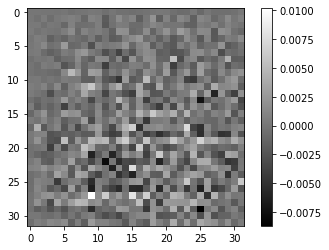

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

---
# 4. 판별자 구현하기
---

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  

    # Fifth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)        

---
# 5. 손실함수와 최적화 함수
---

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- generator_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- discriminator_loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator accuracy

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- 최적화 함수(optimizer)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1 = 0.5)

---
# 6. 훈련과정 설계
---

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음<br><br>
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함<br><br>
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기<br><br>
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성<br><br>
- (5) discriminator 판별 : discriminator가 Real Image인  
images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력<br><br>
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산<br><br>
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산<br><br>
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산<br><br>
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신<br><br>
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴<br><br>

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/EXP 14/image/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)


In [ ]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

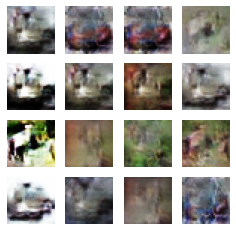

Time for training : 3968 sec


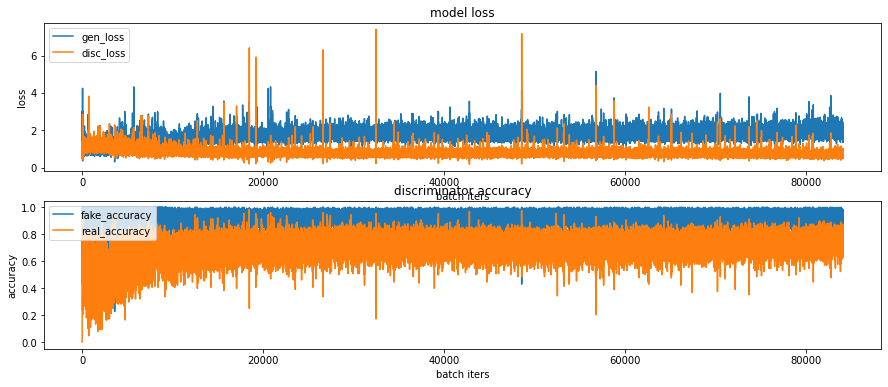

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

----
# 7.학습과정 시각화 하기
----

In [ ]:
anim_file = '/content/drive/MyDrive/aiffel/EXP 14/image/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aiffel/EXP 14/image/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

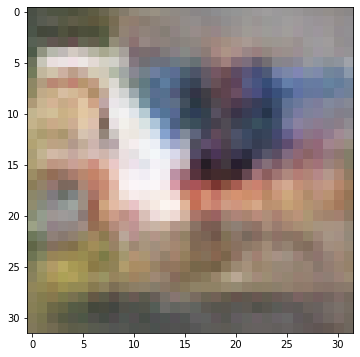

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/EXP 14/image/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
# np_generated = np_generated.astype(int)
plt.imshow((generated_image[0]+1)/2.0)
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

DCGAN을 통해 이미지를 생성한 값을 불러 왔지만 형태를 알아보기 어렵다.

----
# 8.성능 개선해보기
----

---
## 8-1 판별자와 생성자에 conv2D 와 conv2DTranspose 섞어 사용해보기
---

In [ ]:
BUFFER_SIZE2 = 50000
BATCH_SIZE2 = 64

In [ ]:
train_dataset2 = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE2).batch(BATCH_SIZE2)

- 생성자에 conv2DTranspose만 사용하는 것이 아닌 conv2D를 사용하는 방식은 어떠한지 궁금해서 레이어를 변경해 보려 한다.

In [ ]:
def make_generator_model2():

    # Start
    model2 = tf.keras.Sequential()

    # First: Dense layer
    model2.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model2.add(layers.BatchNormalization())
    model2.add(layers.LeakyReLU())

    # Second: Reshape layer
    model2.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model2.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model2.add(layers.BatchNormalization())
    model2.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model2.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model2.add(layers.BatchNormalization())
    model2.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model2.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model2.add(layers.BatchNormalization())
    model2.add(layers.LeakyReLU())

    # sixth: Conv2DTranspose layer
    model2.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model2.add(layers.BatchNormalization())
    model2.add(layers.LeakyReLU())

    # seventh: Conv2DTranspose layer
    model2.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model2

In [ ]:
generator2 = make_generator_model2()

generator2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_20 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 8, 8, 256)        3276800   
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 8, 8, 256)       

- 판별자 역시 conv2D만 사용하는 것이 아닌 conv2DTranspose를 사용해 보겠다.

In [ ]:
def make_discriminator_model2():

    # Start
    model2 = tf.keras.Sequential()

    # First: Conv2D Layer
    model2.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model2.add(layers.LeakyReLU())
    model2.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model2.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model2.add(layers.LeakyReLU())
    model2.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model2.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model2.add(layers.LeakyReLU())
    model2.add(layers.Dropout(0.3))    

    # Fourth: Conv2D Layer
    model2.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model2.add(layers.LeakyReLU())
    model2.add(layers.Dropout(0.3))  

    # Fifth: Flatten Layer
    model2.add(layers.Flatten())

    # sixth: Dense Layer
    model2.add(layers.Dense(1))

    return model2

In [ ]:
discriminator2 = make_discriminator_model2()

discriminator2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 32, 32, 64)       51264     
 Transpose)                                                      
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 64)        0         
                                                      

- 다른 손실함수의 값은 그대로 사용하고 optimizer만 변경해 보겠다.

생성자의 lr은 판별자의 lr보다 상대적으로 크게 하여, 판별자가 더 세세하게 생성된 것을 판별하도록 진행해 보겠다.

In [ ]:
generator_optimizer2 = tf.keras.optimizers.Adam(learning_rate=5e-4)
discriminator_optimizer2 = tf.keras.optimizers.Adam(learning_rate=2e-4)

In [ ]:
@tf.function
def train_step2(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE2, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator2(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output2 = discriminator2(images, training=True)
        fake_output2 = discriminator2(generated_images, training=True)

        #(6) loss 계산
        gen_loss2 = generator_loss(fake_output2)
        disc_loss2 = discriminator_loss(real_output2, fake_output2)

        #(7) accuracy 계산
        real_accuracy2, fake_accuracy2 = discriminator_accuracy(real_output2, fake_output2) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss2, generator2.trainable_variables)
    # training 되는 value들중에서 trainable = TRUE 라는 argument가 추가 되어있을 시, Graphkeys에 자동으로 추가되어 variable objects의 리스트를 리턴한다
    gradients_of_discriminator = disc_tape.gradient(disc_loss2, discriminator2.trainable_variables)

    #(9) 모델 학습
    generator_optimizer2.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))
    discriminator_optimizer2.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss2, disc_loss2, real_accuracy2, fake_accuracy2  #(10) 리턴값

In [ ]:
def generate_and_save_images2(model, epoch, it, sample_seeds):

    predictions2 = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions2.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions2[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image2/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history2(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image2/training_history2/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir2 = '/content/drive/MyDrive/aiffel/EXP 14/image2/training_checkpoints2'

checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt")
checkpoint2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator2,
                                 discriminator=discriminator2)

In [ ]:
def train2(dataset, epochs, save_every):
    start = time.time()
    history2 = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss2, disc_loss2, real_accuracy2, fake_accuracy2 = train_step2(image_batch)
            history2['gen_loss'].append(gen_loss2)
            history2['disc_loss'].append(disc_loss2)
            history2['real_accuracy'].append(real_accuracy2)
            history2['fake_accuracy'].append(fake_accuracy2)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images2(generator2, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint2.save(file_prefix=checkpoint_prefix2)

        display.clear_output(wait=True)
        generate_and_save_images2(generator2, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history2(history2, epoch)


In [ ]:
save_every2 = 50
EPOCHS2 = 300

- 결론 적으로 바뀐 값은 아래와 같다.
  - batch_size = 128 -> 64 변경
  - generator = conv2D 추가
  - discriminator = conv2DTranspose 추가
  - generator_optimizer = 2e-4 -> 5e-4 변경

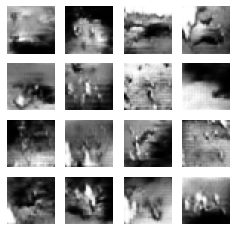

Epoch 41 | iter 401
Time for epoch 41 : 39 sec


KeyboardInterrupt: ignored

In [ ]:
%%time
train2(train_dataset2, EPOCHS2, save_every2)

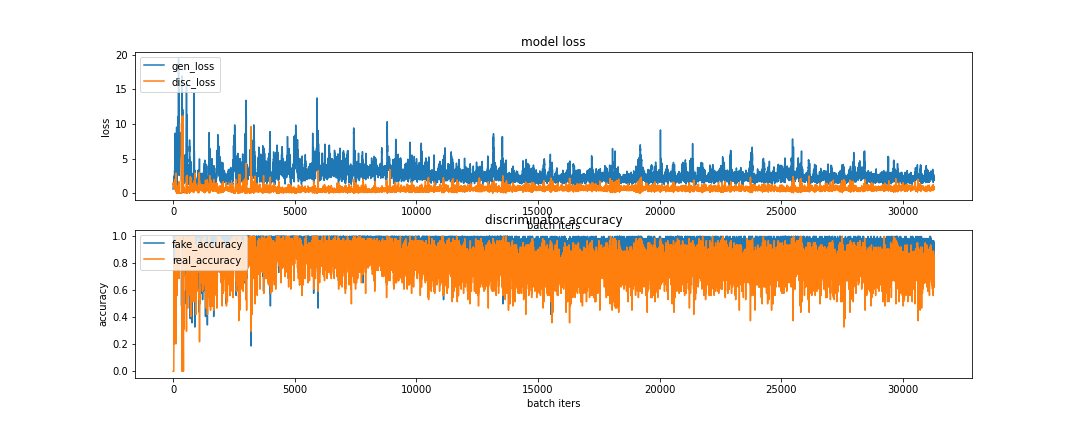

- 진행하는 과정에서 색상값을 잘 못 건들여서 흑백으로 학습이 진행되었다. 
- 추후 발견한 결과 generate_and_save_images2를 생성하는 함수에서 cmap = 'gray'를 지우지 않았음을 확인하였다.
- 현재 history값을 이전과 비교해 보면 같은 epoch일때, 현재의 값이 더 1에 가까워지고 있음을 볼 수 있다. 
- 중간 확인을 해본 결과, 이미 결과값이 좋지 못하다고 생각해 중단을 하였다.
- 생성자에 conv2D를 쓴 값을 인터넷에 찾아보았지만 없었다. 만약 다시 사용할 기회가 된다면 생성자와 판별자에 반대의 conv의 값을 1개씩만 쌓는 것이 아닌 2~3개 이상 쌓아서 다시 테스트 해보고 싶다.

---
## 8-2. SRGAN
---

- SRGAN은 화질을 개선하는 GAN이라는 것을 알게되었고 위 이미지를 복원할 수 있는지 확인해 보겠다.

- 이전 아이펠 학습과정에서 있던 exploration을 참고하였다.  
해당 익스에는 SRGAN을 활용해 이미지를 복원하는 과정인 것 같다.   
SRGAN이 학습된 데이터셋을 찾고 불러와 현재 이미지를 복원할 수 있는지 테스트 해보겠다.


In [ ]:
import cv2
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

- SRGAN을 적용하는 함수 생성

In [ ]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

---
## 8-2-1 SRGAN 성능 TEST
---

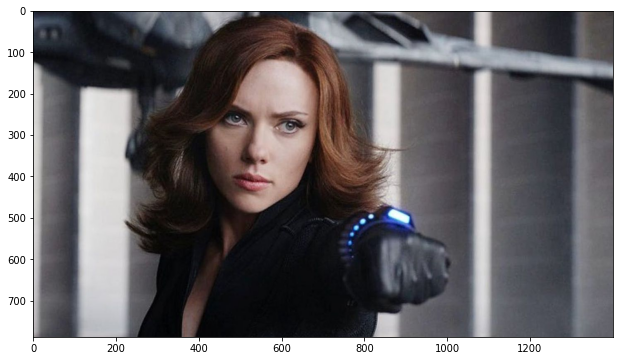

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/EXP 14/test.jpeg'
img2 = cv2.imread(image_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [ ]:
img2 = cv2.resize(img2, dsize=(1400,800))

In [ ]:
img2.shape

(800, 1400, 3)

- Bicubic interpolation :  
  Cubic interpolation을 x축과 y축으로 각각 실행하여 구할 수 있음.  
  하나의 값을 결정하는 데에 인접한 16개의 화소값이 필요함.  

In [ ]:
## bicubic interpolation
bicubic_lr2 = cv2.resize(
    img2, 
    dsize=(img2.shape[1]//4, img2.shape[0]//4), # 저해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

bicubic_hr2 = cv2.resize(
    bicubic_lr2, 
    dsize=(img2.shape[1], img2.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [ ]:
sr2 = apply_srgan(bicubic_lr2)

In [ ]:
print(bicubic_hr2.shape)
print(sr2.shape)
print(img2.shape)

(800, 1400, 3)
(800, 1400, 3)
(800, 1400, 3)


In [ ]:
images2 = [bicubic_hr2, sr2, img2]
labels2 = ["Bicubic", "SRGAN", "Origin"]

psnr = [round(peak_signal_noise_ratio(img2, i), 3) for i in images2]
ssim = [round(structural_similarity(img2, i, multichannel=True), 3) for i in images2]

plt.figure(figsize=(30,30))
for i in range(3):
    plt.subplot(3,1,i+1) 
    plt.imshow(images2[i])
    plt.title(labels2[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=15)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

성능적으로 많이 뛰어나지는 않지만 Bicubic과 비교해 얼굴의 좌측 부분, 팔찌 등 부분은 선명하게 드러나고 있다.

---
## 8-2-2 Cifar10 이미지 복원 해보기
---

- 사전 학습된 데이터셋 불러오기

In [ ]:
model_file = '/content/drive/MyDrive/aiffel/EXP 14/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

- cifar10의 이미지 랜덤으로 불러오기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


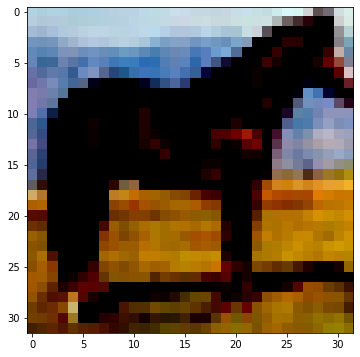

In [ ]:
random_index = np.random.randint(1, 50000)
plt.imshow(train_x[random_index])

In [ ]:
img = train_x[random_index]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
## bicubic interpolation
bicubic_hr = cv2.resize(
    img, 
    dsize=(img.shape[1]*4, img.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [ ]:
## SRGAN
sr = apply_srgan(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


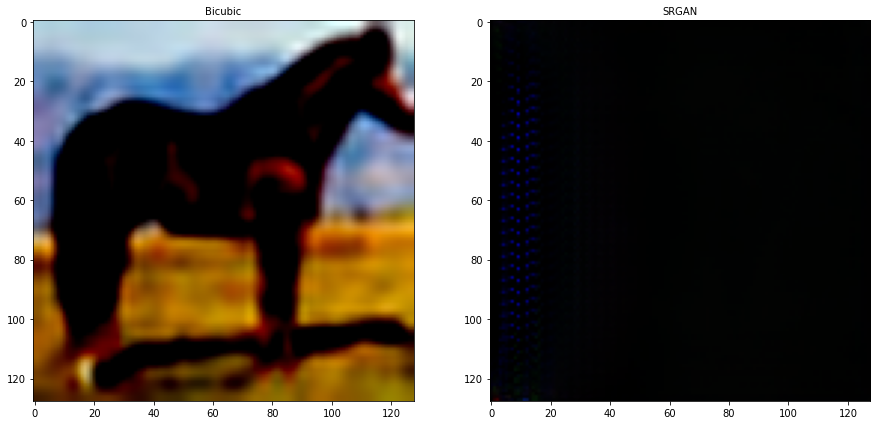

In [ ]:
images = [bicubic_hr, sr]
labels = ["Bicubic", "SRGAN"]

plt.figure(figsize=(15,15))
for i in range(2):
    plt.subplot(1,2,i+1) 
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i], fontsize=10)

32 * 32의 사이즈를 각 4배씩 늘려진 형태이다.  

Bicubic의 경우 사이즈를 늘리면서 빈 값을 계산을 통해서 채워넣어진 상태이며,  
주변 값을 참조해 이미지를 생성한 것이다 보니 이전의 네모난 픽셀이 보이는 것은 상당히 적어졌다.  

SRGAN의 경우 학습된 모델을 불러왔지만 기존의 이미지 자체가  
32*32의 너무 작고 형태을 알아보기 힘든 이미지이기 때문에 모델이 이미지를 인지하지 못한 상황인 것 같다.

---
## 8-3 이미지 사이즈 변경 및 보간법을 통해 개선 후 넣어보기
----

저화질의 이미지의 사이즈를 키우고 bicubic 보간법을 통해 어느정도 화질의 개선을 한 후,  
해당 이미지 데이터를 input값에 써 보겠다.

In [ ]:
img_up = tf.image.resize(train_x,(128,128),method='bicubic') 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50000, 32, 32, 3)

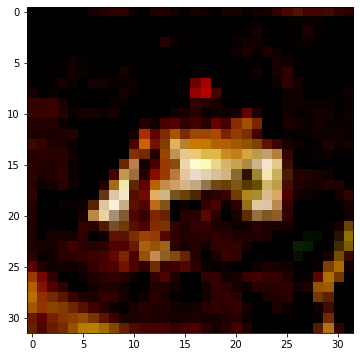

In [ ]:
plt.imshow(train_x[0])
train_x.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TensorShape([50000, 128, 128, 3])

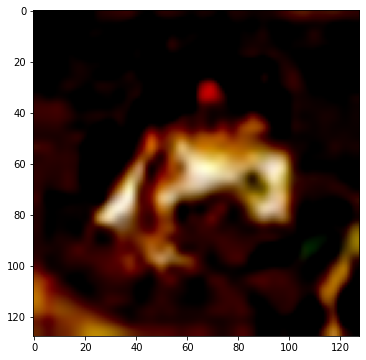

In [ ]:
plt.imshow(img_up[0])
img_up.shape

이미지 shape이 증가 및 보간법을 통해 각진 이미지가 나름 개선이 된 것을 볼 수 있다.

In [ ]:
BUFFER_SIZE3 = 50000
BATCH_SIZE3 = 64

In [ ]:
train_dataset3 = tf.data.Dataset.from_tensor_slices(img_up).shuffle(BUFFER_SIZE3).batch(BATCH_SIZE3)

- 생성자는 128,128,3에 맞게끔 Layer를 늘려주었다.

In [ ]:
def make_generator_model3():

    # Start
    model3 = tf.keras.Sequential()

    # First: Dense layer
    model3.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.LeakyReLU())

    # Second: Reshape layer
    model3.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model3.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model3.add(layers.BatchNormalization())
    model3.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model3.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model3.add(layers.BatchNormalization())
    model3.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model3.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model3.add(layers.BatchNormalization())
    model3.add(layers.LeakyReLU())

    # sixth: Conv2DTranspose layer
    model3.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model3.add(layers.BatchNormalization())
    model3.add(layers.LeakyReLU())

    # seventh: Conv2DTranspose layer
    model3.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model3

In [ ]:
generator3 = make_generator_model3()

generator3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8192)              819200    
                                                                 
 batch_normalization_39 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_75 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_39 (Conv2D  (None, 8, 8, 256)        3276800   
 Transpose)                                                      
                                                                 
 batch_normalization_40 (Bat  (None, 8, 8, 256)      

- 판별자 역시 초기 input값을 128,128,3으로 설정하고 Layer의 층을 깊게 쌓았다.

In [ ]:
def make_discriminator_model3():

    # Start
    model3 = tf.keras.Sequential()

    # First: Conv2D Layer
    model3.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', input_shape=[128, 128, 3]))
    model3.add(layers.LeakyReLU())
    model3.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model3.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model3.add(layers.LeakyReLU())
    model3.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model3.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model3.add(layers.LeakyReLU())
    model3.add(layers.Dropout(0.3))    

    # Fourth: Conv2D Layer
    model3.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model3.add(layers.LeakyReLU())
    model3.add(layers.Dropout(0.3))  

    # Fifth: Flatten Layer
    model3.add(layers.Flatten())

    # sixth: Dense Layer
    model3.add(layers.Dense(1))

    return model3

In [ ]:
discriminator3 = make_discriminator_model3()

discriminator3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout_36 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_37 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)      

- optimizer를 RMSprop로 바꾸었다.

In [ ]:
generator_optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=5e-4)
discriminator_optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=2e-4)

In [ ]:
@tf.function
def train_step3(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE3, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator3(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output3 = discriminator3(images, training=True)
        fake_output3 = discriminator3(generated_images, training=True)

        #(6) loss 계산
        gen_loss3 = generator_loss(fake_output3)
        disc_loss3 = discriminator_loss(real_output3, fake_output3)

        #(7) accuracy 계산
        real_accuracy3, fake_accuracy3 = discriminator_accuracy(real_output3, fake_output3) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss3, generator3.trainable_variables)
    # training 되는 value들중에서 trainable = TRUE 라는 argument가 추가 되어있을 시, Graphkeys에 자동으로 추가되어 variable objects의 리스트를 리턴한다
    gradients_of_discriminator = disc_tape.gradient(disc_loss3, discriminator3.trainable_variables)

    #(9) 모델 학습
    generator_optimizer3.apply_gradients(zip(gradients_of_generator, generator3.trainable_variables))
    discriminator_optimizer3.apply_gradients(zip(gradients_of_discriminator, discriminator3.trainable_variables))

    return gen_loss3, disc_loss3, real_accuracy3, fake_accuracy3  #(10) 리턴값

In [ ]:
def generate_and_save_images3(model, epoch, it, sample_seeds):

    predictions3 = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions3.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions3[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image3/generated_samples3/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history3(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/EXP 14/image3/training_history3/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir3 = '/content/drive/MyDrive/aiffel/EXP 14/image3/training_checkpoints3'

checkpoint_prefix3 = os.path.join(checkpoint_dir3, "ckpt")
checkpoint3 = tf.train.Checkpoint(generator_optimizer=generator_optimizer3,
                                 discriminator_optimizer=discriminator_optimizer3,
                                 generator=generator3,
                                 discriminator=discriminator3)

In [ ]:
def train3(dataset, epochs, save_every):
    start = time.time()
    history3 = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss3, disc_loss3, real_accuracy3, fake_accuracy3 = train_step3(image_batch)
            history3['gen_loss'].append(gen_loss3)
            history3['disc_loss'].append(disc_loss3)
            history3['real_accuracy'].append(real_accuracy3)
            history3['fake_accuracy'].append(fake_accuracy3)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images3(generator3, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint3.save(file_prefix=checkpoint_prefix3)

        display.clear_output(wait=True)
        generate_and_save_images3(generator3, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history3(history3, epoch)


In [ ]:
save_every3 = 10
EPOCHS3 = 100

- 결론 적으로 바뀐 값은 아래와 같다.
  - dataset shape = (32,32,3) -> (128,128,3)
  - 생성자 및 판별자 레이어 추가
  - optimizer = Adam -> RMSprop

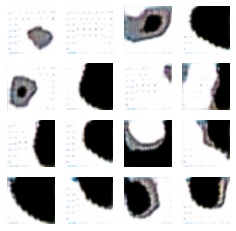

Epoch 52 | iter 601
Time for epoch 52 : 104 sec


KeyboardInterrupt: ignored

In [ ]:
%%time
train3(train_dataset3, EPOCHS3, save_every3)

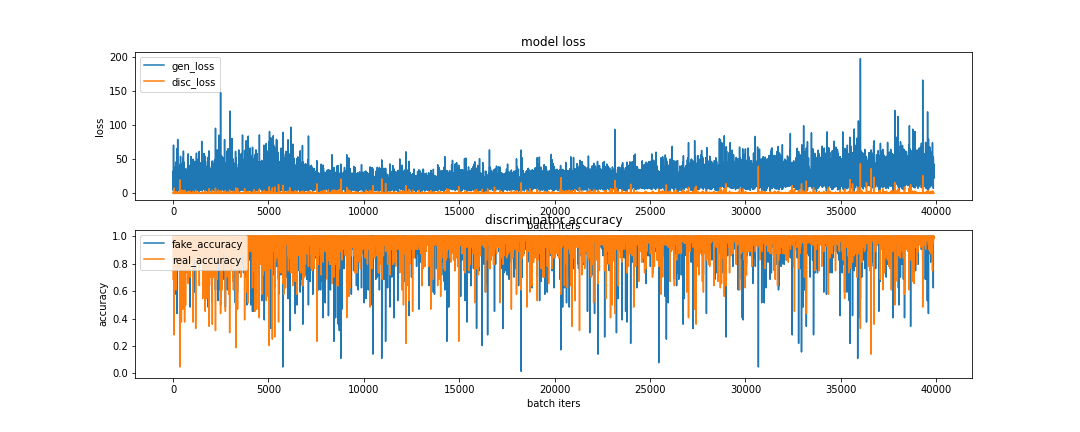

판별자의 성능이 1에 가까운 수준으로 높아졌다.  
생성자의 이미지 생성 능력이 떨어져 real_accuracy 그래프가 fake_accuracy 그래프를 덮어 버렸다.  
굉장히 망한 모델을 만들어 버렸다.

----
# 8-4 Layer층을 깊게 쌓아보기
----

- 이번에는 판별자와 생성자의 각 레이어의 층을 깊게 쌓아 보겠다.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((2, 2, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # seven: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(16, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # eighth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(8, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # ninth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              204800    
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 256)         0

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(8, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  

    # Fifth: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  
    
    # sixth: Flatten Layer
    model.add(layers.Flatten())

    # seventh: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        3216      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)       

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
discriminator_optimizer = tf.keras.optimizers.Nadam(learning_rate=2e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 25
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- 생성자 9개층 / 판별자 7개 층으로 깊이 쌓았다.
- 해당 모델은 아이펠 서버에서 돌린 후 가져왔다.

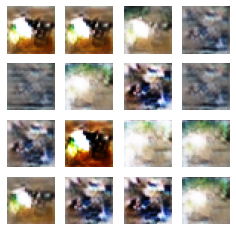

Epoch 253 | iter 251
Time for epoch 253 : 9 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

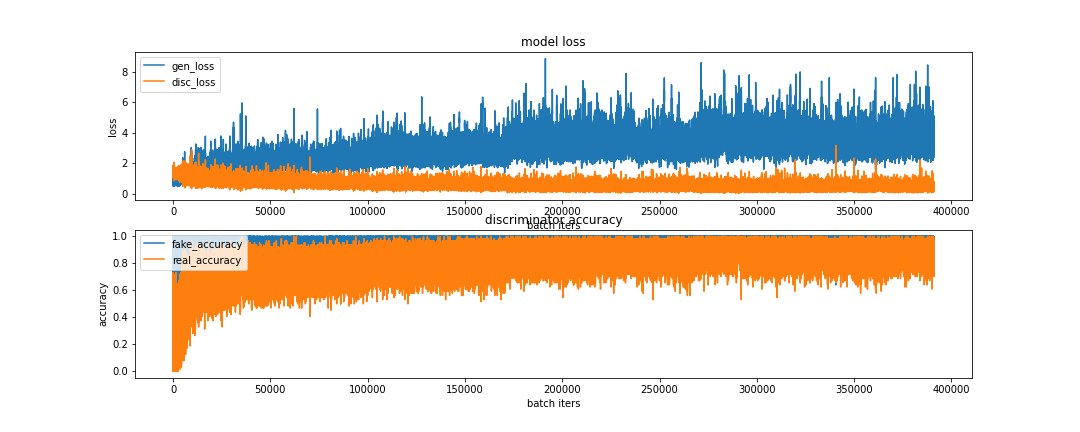

- 점점 real_accuracy가 1에 가까워져가고 있다.
- 이 또한 망했다;;

---
# 9. 회고
---

- DCGAN의 정확도를 0.5에 수렴하도록 만드는 것이 매우 어려웠다.
- cifar-10의 이미지가 32*32의 작고 시각적으로 보기 어려운 이미지 이다 보니. DCGAN을 돌려 나온 이미지의 값도 시각적으로 확인하기 어려웠다.
- 이미지를 개선하고자 찾다가 SRGAN과 Bicubic을 알게되었고, input이미지가 별로다 보니 SRGAN으로는 화질을 개선할 수 없었고, 낮은 화질에서는 차라리 Bicubic이 더 좋은 성능을 보여주었다.
- 처음에 SRGAN이 성능이 뛰어날 것이라고 예상하여 위에 넣은 블랙위도우의 이미지를 블러 처리된 이미지를 넣었으나, 선명해 지지 못했고, 선명한 이미지를 넣어도 엄청 개선되는 이미지를 보여주지는 않아 조금은 실망스러웠다.
- 다른 Git을 통해서 본 SRGAN은 양호한 성능을 보여주었는데, 다운받은 h5파일의 훈련량 및 훈련성능이  좋지 못한 것일 수 있다고 생각이 들었다.
- 생성자에 conv2D를, 판별자에 conv2DTranspose를 넣는 방식, 이미지의 사이즈를 키운 후 테스트 해보는 등 다양한 고민과 발상을 해보았지만 결과적으로는 모두 실패에 가까운 수준이었다. 
- 코드를 복붙하는 과정에서 실수가 발생한 것인지, 아니면 실제로 영향이 미미한 것인지 알 수 없어서 답답했다.
- 여러가지 시도를 해보고 싶었지만 시간적 여유가 없어서 다양한 시도를 못 했고, epoch값 또한 천 단위로 돌려보지 못하였고, 결과값 또한 지속적으로 망한 모델이 나와서 흥미를 잃었던 과제였다. 
- 특히 판별자와 생성자에 conv2D와 conv2DTranspose 섞어서 쓰는 모델을 뒤늦게 돌려보았지만 생각보다 한 epoch당 많은 시간이 걸려서 결과값을 확인하지 못해, 가져오지 못 했다. 


- 그나마 성능이 나았던 첫 번째 모델을 돌린 후 나온 이미지의 gif 링크이다.  
https://drive.google.com/file/d/1oDRUVII8xkZOgFjIJhFyugad-ArBb10L/view?usp=sharing